In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

# load data

In [100]:
# read json files
path='/content/mastodon2.json'
with open(path) as json_data:
  obj = json.load(json_data)
  df_m = pd.DataFrame(obj['data']['platforms'][0]['statSet'], columns=['date','usersMonthly','usersTotal'])

In [101]:
# initial data process
df_m['date'] = pd.to_datetime(df_m['date'])
df_m = df_m.sort_values(by='date')

# mask = df_m['date']>'2021-12-31'
# df_m = df_m.loc[mask].reset_index(drop=True)

In [102]:
# extract Novemember Data
Nov_interval = ('2022-10-21','2022-11-21')
mask1=(df_m['date'] >= Nov_interval[0]) & (df_m['date'] <= Nov_interval[1])
df1 = df_m.loc[mask1].reset_index(drop=True)
df1['Diff'] = df1['usersTotal'].diff()
df1.at[0,'Diff']=0

In [103]:
len(df1)

32

In [104]:
# split data to X/input and Y/output, 7days for predicting the 8th day
d=df1["Diff"].to_numpy()
len_x = 7
len_y = 1
width = len_x + len_y
thing = [d[i:] for i in range(width)]
# print(thing)
min_length = min(len(x) for x in thing)
thing = [x[:min_length] for x in thing]
thing = np.stack(thing, axis=1)
# print(thing)
data = thing[:, :len_x]
target = thing[:, len_x:]

print(data.shape)
print(target.shape)

(25, 7)
(25, 1)


# plot features(new infections)

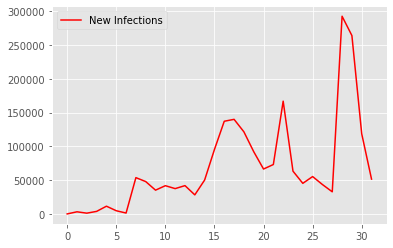

In [105]:
plt.style.use('ggplot')
plt.plot(df1['Diff'],label='New Infections',c='red')
plt.legend()
plt.show()

In [106]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(data)
y_mm = mm.fit_transform(target) 

In [107]:
X_ss.dtype

dtype('float64')

In [108]:
print(X_ss.shape,y_mm.shape)  #minmax scalar for each column

(25, 7) (25, 1)


In [109]:
# split to train and test

X_train = X_ss[:X_ss.shape[0]-2, :]
y_train = y_mm[:X_ss.shape[0]-2, :]

X_valid = X_ss[-2:, :]
y_valid = y_mm[-2:, :] 
print("Training Shape", X_train.shape, y_train.shape)
print("Validation Shape", X_valid.shape, y_valid.shape) 

Training Shape (23, 7) (23, 1)
Validation Shape (2, 7) (2, 1)


# LSTM

In [110]:
import torch 
import torch.nn as nn
from torch.autograd import Variable

In [111]:
def Tensor_Process(arr,reshape=True):
  if reshape:
    tensor=Variable(torch.Tensor(arr))
    return torch.reshape(tensor,  (tensor.shape[0],1,tensor.shape[1]))
  else:
    return Variable(torch.Tensor(arr))

In [112]:
X_train_tensors = Tensor_Process(X_train)
y_train_tensors = Tensor_Process(y_train,reshape=False)

X_valid_tensors = Tensor_Process(X_valid)
y_valid_tensors = Tensor_Process(y_valid,reshape=False)

In [113]:
print(X_train_tensors.shape,y_train_tensors.shape)
print(X_valid_tensors.shape,y_valid_tensors.shape)
print(X_train.dtype)

torch.Size([23, 1, 7]) torch.Size([23, 1])
torch.Size([2, 1, 7]) torch.Size([2, 1])
float64


In [114]:
#reshaping to rows, timestamps, features
# X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

# X_valid_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [115]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [116]:
num_epochs = 1000
learning_rate = 0.001

input_size = 7 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

In [117]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors.shape[1]) #our lstm class 

In [118]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [119]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.23897
Epoch: 100, loss: 0.05219
Epoch: 200, loss: 0.04668
Epoch: 300, loss: 0.04312
Epoch: 400, loss: 0.04095
Epoch: 500, loss: 0.04024
Epoch: 600, loss: 0.03997
Epoch: 700, loss: 0.03987
Epoch: 800, loss: 0.03981
Epoch: 900, loss: 0.03947


# Validation

In [120]:
# def nan_pad(arr):
  # zero_pad=np.empty((df_y_mm.shape[0]-1+7,))
  # # print(zero_pad.shape)
  # zero_pad.fill(np.NaN)
  # zero_pad[-7:]=data_predict
  # print(zero_pad)

In [124]:
lstm1.eval()
with torch.no_grad():
  print('Input x\n',data[-2:, :])
  print('GT y\n',target[-2:,:])

  train_predict = lstm1(X_valid_tensors)  #forward pass
  y_predict_un = train_predict.data.numpy() #numpy conversion
  y_predict = mm.inverse_transform(y_predict_un) #reverse transformation
  print('Pred y\n',y_predict)

  dataY_plot = y_mm  # ground truth
  dataY_plot = mm.inverse_transform(dataY_plot)
  # print(dataY_plot)

Input x
 [[ 63260.  45237.  55255.  43454.  32700. 292433. 263862.]
 [ 45237.  55255.  43454.  32700. 292433. 263862. 118529.]]
GT y
 [[118529.]
 [ 51477.]]
Pred y
 [[146014.19 ]
 [ 31210.037]] 

 [[0.44591218]
 [0.01146268]]


In [148]:
print(X_valid)
print('\n',y_predict_un)

# print(data[-2:, :].dtype)
y_predict_un=y_predict_un.astype(np.float64)

print(X_valid.dtype,y_predict_un.dtype)

input1=np.append(X_valid[1,1:],y_predict_un[1]).reshape(1,-1)
# input2=np.append(X_valid[1,1:],y_predict_un[1])
# input1=np.vstack((input1,input2))
print(input1,input1.shape)
# res=mm.fit_transform(list1)
# res

[[ 0.18741475 -0.25161779 -0.06881787 -0.37409289 -0.62595932  2.98484392
   2.56834577]
 [-0.19725922 -0.0315133  -0.33529279 -0.62378038  3.60641146  2.58109691
   0.47249647]]

 [[0.44591218]
 [0.01146268]]
float64 float64
[[-0.0315133  -0.33529279 -0.62378038  3.60641146  2.58109691  0.47249647
   0.01146268]] (1, 7)


In [162]:
# lst=np.append(lst,y_predict).reshape(1,-1)
# print(lst,lst.shape,'\n')
# print(lst[-7:])

def predict_test(arr,days):
  output=[]
  lstm1.eval()
  with torch.no_grad():
    i=0
    while i<days:
      # new=arr[-days:].reshape(1,-1).copy()
      print('orig\n',arr[:,-days:],arr[:,-days:].shape)

      X_test_tensors=Tensor_Process(arr[:,-days:])
      print(X_test_tensors.shape)
      test_pred=lstm1(X_test_tensors)
      y_predict = test_pred.data.numpy().flatten()
      print("predictaion",y_predict[0])
      arr=np.append(arr,y_predict).reshape(1,-1)    # arr=np.append(arr[0],y_predict)
      i+=1
    return arr

days=7
pred_result=predict_test(input1,days)
print(pred_result[:,-days:])
pred_result=mm.inverse_transform(pred_result)
print(pred_result[:,-days:].flatten())

orig
 [[-0.0315133  -0.33529279 -0.62378038  3.60641146  2.58109691  0.47249647
   0.01146268]] (1, 7)
torch.Size([1, 1, 7])
predictaion 0.44591218
orig
 [[-0.33529279 -0.62378038  3.60641146  2.58109691  0.47249647  0.01146268
   0.44591218]] (1, 7)
torch.Size([1, 1, 7])
predictaion 0.15027028
orig
 [[-0.62378038  3.60641146  2.58109691  0.47249647  0.01146268  0.44591218
   0.15027028]] (1, 7)
torch.Size([1, 1, 7])
predictaion 0.24688998
orig
 [[3.60641146 2.58109691 0.47249647 0.01146268 0.44591218 0.15027028
  0.24688998]] (1, 7)
torch.Size([1, 1, 7])
predictaion 0.44591218
orig
 [[2.58109691 0.47249647 0.01146268 0.44591218 0.15027028 0.24688998
  0.44591218]] (1, 7)
torch.Size([1, 1, 7])
predictaion 0.44591218
orig
 [[0.47249647 0.01146268 0.44591218 0.15027028 0.24688998 0.44591218
  0.44591218]] (1, 7)
torch.Size([1, 1, 7])
predictaion 0.42100048
orig
 [[0.01146268 0.44591218 0.15027028 0.24688998 0.44591218 0.44591218
  0.42100048]] (1, 7)
torch.Size([1, 1, 7])
predictaion 0.3

In [163]:
gt_axe=np.arange(0,32)
print(len(gt_axe))
pred_axe=np.arange(32,32+days)
print(len(pred_axe))

32
7


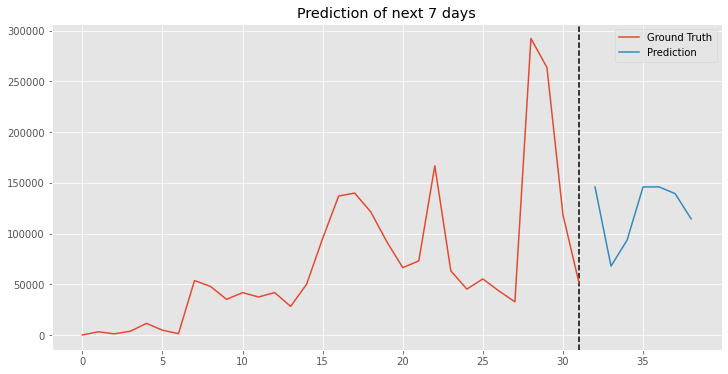

In [164]:
plt.figure(figsize=(12,6)) #plotting
plt.title('Prediction of next 7 days')
plt.axvline(x=31, c='black', linestyle='--') #size of the training set


plt.plot(gt_axe,df1['Diff'], label='Ground Truth') #actual plot
plt.plot(pred_axe,pred_result[:,-days:].flatten(),label='Prediction') #predicted plot

plt.legend()
plt.show() 